In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from tree_based_models import model_selection_using_kfold, get_model
from sklearn.impute import SimpleImputer

In [11]:
# Clinical Data
clinical_train = pd.read_csv("data/X_train/clinical_train.csv")
clinical_test = pd.read_csv("data/X_test/clinical_test.csv")

# Molecular Data
molecular_train = pd.read_csv("data/X_train/molecular_train.csv")
molecular_test = pd.read_csv("data/X_test/molecular_test.csv")

target_train = pd.read_csv("data/X_train/target_train.csv")

# Preview the data
clinical_train.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


## Data Preprocessing

In [12]:
train = pd.concat(
    [
        clinical_train.set_index("ID").select_dtypes(include="number"),
        target_train.set_index("ID"),
    ],
    axis=1,
)
train = train[~train["OS_YEARS"].isna()]
train.head()

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,OS_YEARS,OS_STATUS
ID,,,,,,,,
P132697,14.0,2.8,0.2,0.7,7.6,119.0,1.115068,1.0
P132698,1.0,7.4,2.4,0.1,11.6,42.0,4.928767,0.0
P116889,15.0,3.7,2.1,0.1,14.2,81.0,2.043836,0.0
P132699,1.0,3.9,1.9,0.1,8.9,77.0,2.476712,1.0
P132700,6.0,128.0,9.7,0.9,11.1,195.0,3.145205,0.0


In [13]:
tmp = molecular_train.groupby("ID").size().to_frame("Nmut")
train = train.merge(tmp, left_index=True, right_index=True, how="inner")

In [14]:
train.columns

Index(['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT', 'OS_YEARS',
       'OS_STATUS', 'Nmut'],
      dtype='object')

## Kfold

In [15]:
target = "OS_YEARS"
features = ["BM_BLAST", "WBC", "HB", "PLT", "Nmut"]
model_type = "xgb"

Fold 1 - IPCW C-index (Train: 0.7146 | Test: 0.6697)
Fold 2 - IPCW C-index (Train: 0.7181 | Test: 0.6746)
Fold 3 - IPCW C-index (Train: 0.7168 | Test: 0.6886)
Fold 4 - IPCW C-index (Train: 0.7203 | Test: 0.6666)
Fold 5 - IPCW C-index (Train: 0.7228 | Test: 0.6573)
Fold 6 - IPCW C-index (Train: 0.7189 | Test: 0.6684)
IPCW C-index: 0.6709 (± 0.0095) [Min: 0.6573 ; Max: 0.6886]

Top 10 important features:
['PLT', 'HB', 'Nmut', 'BM_BLAST', 'WBC']


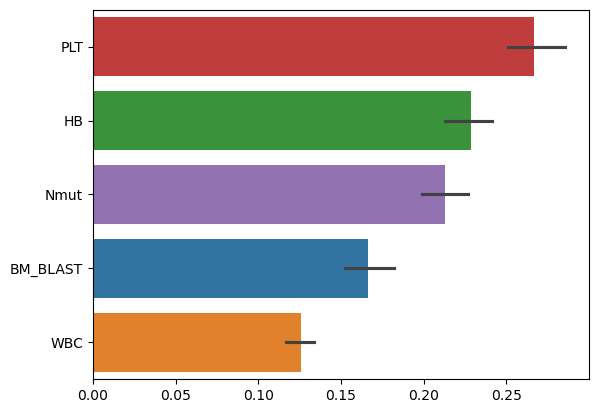

In [16]:
model_selection_using_kfold(
    data=train.reset_index(),
    target=target,
    features=features,
    model_type=model_type,
    feat_engineering=None,
    unique_id="ID",
    plot_ft_importance=True,
    n_splits=6,
    log=False,
)

## Eval

In [17]:
test = clinical_test

tmp = molecular_test.groupby("ID").size().to_frame("Nmut")
test = test.merge(tmp, on="ID", how="left").fillna({"Nmut": 0})
test

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,Nmut
0,KYW1,KYW,68.0,3.45,0.5865,NaN,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]",4.0
1,KYW2,KYW,35.0,3.18,1.2402,NaN,10.0,32.0,"46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de...",3.0
2,KYW3,KYW,NaN,12.40,8.6800,NaN,12.3,25.0,"47,XX,+8",3.0
3,KYW4,KYW,61.0,5.55,2.0535,NaN,8.0,44.0,Normal,3.0
4,KYW5,KYW,2.0,1.21,0.7381,NaN,8.6,27.0,"43,XY,dic(5;17)(q11.2;p11.2),-7,-13,-20,-22,+r...",3.0
...,...,...,...,...,...,...,...,...,...,...
1188,KYW1189,KYW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1189,KYW1190,KYW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1190,KYW1191,KYW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1191,KYW1192,KYW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [18]:
test[features]

,BM_BLAST,WBC,HB,PLT,Nmut
0,68.0,3.45,7.6,48.0,4.0
1,35.0,3.18,10.0,32.0,3.0
2,NaN,12.40,12.3,25.0,3.0
3,61.0,5.55,8.0,44.0,3.0
4,2.0,1.21,8.6,27.0,3.0
...,...,...,...,...,...
1188,NaN,NaN,NaN,NaN,2.0
1189,NaN,NaN,NaN,NaN,3.0
1190,NaN,NaN,NaN,NaN,1.0
1191,NaN,NaN,NaN,NaN,3.0


In [19]:
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(train[features])
X_test = imputer.transform(test[features])

model = get_model(model_type=model_type)
model.fit(X_train, train[target])
preds = -model.predict(X_test)

submission = pd.Series(preds, index=test["ID"], name="risk_score")
submission

ID
KYW1      -1.863237
KYW2      -1.967832
KYW3      -2.254613
KYW4      -1.863237
KYW5      -2.051965
             ...   
KYW1189   -2.487625
KYW1190   -2.487625
KYW1191   -2.508197
KYW1192   -2.487625
KYW1193   -2.487625
Name: risk_score, Length: 1193, dtype: float32

In [20]:
submission.to_csv("data/base_submission.csv")

In [21]:
submission

ID
KYW1      -1.863237
KYW2      -1.967832
KYW3      -2.254613
KYW4      -1.863237
KYW5      -2.051965
             ...   
KYW1189   -2.487625
KYW1190   -2.487625
KYW1191   -2.508197
KYW1192   -2.487625
KYW1193   -2.487625
Name: risk_score, Length: 1193, dtype: float32

In [22]:
len(
    set(pd.read_csv("data/benchmark_submission.csv")["ID"]) & set(submission.index)
) / len(set(submission.index))

1.0